In [18]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from behav_analysis import Data_Functions
from behav_analysis import Participant

def c_to_f(temp):
    """Convert celsius to fahrenheit"""
    
    return round(temp * 9/5 + 32, 2)

def get_exp_ts(df, exp_name):
    df_new = df[df["exp_name"] == exp_name]
    start_ts = df_new["start_timestamp"].item()
    end_ts = df_new["end_timestamp"].item()

    return start_ts, end_ts

def get_exp_dt(df, exp_name):
    df_new = df[df["exp_name"] == exp_name]
    start_dt = datetime.datetime.fromtimestamp(df_new["start_timestamp"].item()/1e9)
    end_dt = datetime.datetime.fromtimestamp(df_new["end_timestamp"].item()/1e9)

    return start_dt, end_dt

def plot_exp_regions(par, marker_df, ax):
    for exp_name in par.exp_order:
        start_dt, end_dt = get_exp_dt(marker_df, exp_name=exp_name)
        ax.axvline(start_dt, linestyle="dashed", color="k", alpha=0.75)
        ax.axvline(end_dt, linestyle="dashed", color="k", alpha=0.75)
        if exp_name == "audio_narrative":
            ax.axvspan(start_dt, end_dt, color="yellow", alpha=0.4, label="Audio Narrative")
        elif exp_name == "go_no_go":
            ax.axvspan(start_dt, end_dt, color="green", alpha=0.4, label="Go//No-Go")
        elif exp_name == "king_devick":
            ax.axvspan(start_dt, end_dt, color="blue", alpha=0.4, label="King Devick")
        elif exp_name == "n_back":
            ax.axvspan(start_dt, end_dt, color="purple", alpha=0.4, label="N-back")
        elif exp_name == "resting_state":
            ax.axvspan(start_dt, end_dt, color="pink", alpha=0.4, label="Resting State")
        elif exp_name == "tower_of_london":
            ax.axvspan(start_dt, end_dt, color="orange", alpha=0.4, label="Tower of London")
        elif exp_name == "video_narrative_cmiyc":
            ax.axvspan(start_dt, end_dt, color="red", alpha=0.4, label="Video Narrative CMIYC")
        elif exp_name == "video_narrative_sherlock":
            ax.axvspan(start_dt, end_dt, color="olive", alpha=0.4, label="Video Narrative Sherlock")
        elif exp_name == "vSAT":
            ax.axvspan(start_dt, end_dt, color="cyan", alpha=0.4, label="vSAT")
    
class Participant_Watch():
    def __init__(self, par_num):
        self.par_num = par_num
        self.par_ID = f"participant_{self.par_num}"
        self.par_dir = os.path.join(os.getcwd(), "participants", self.par_ID)
        self._dir_list = self._get_data_dirs()
        self.modalities = ["ACC", "BVP", "EDA", "HR", "IBI", "TEMP"] 

        self.ACC_df = self._modality_df("ACC")
        self.BVP_df = self._modality_df("BVP")
        self.EDA_df = self._modality_df("EDA")
        self.HR_df = self._modality_df("HR")
        self.TEMP_df = self._modality_df("TEMP")

    def _get_data_dirs(self):
        watch_dir = os.path.join(self.par_dir, "watch_data")
        dir_list = []
        for dir_name in os.listdir(watch_dir):
            dir_list.append(os.path.join(watch_dir, dir_name))

        return dir_list

    def _modality_df(self, modality):
        df = pd.DataFrame()
        for i, watch_dir in enumerate(self._dir_list):
            filepath = os.path.join(watch_dir, modality + ".csv")
            temp_df = pd.read_csv(filepath)
            
            initial_ts = int(float(temp_df.columns[0]))
            samp_freq = int(temp_df.iloc[0][0])
            ts_col = pd.Series([initial_ts + i/samp_freq for i in range(temp_df.size)])
            dt_col = pd.Series([datetime.datetime.fromtimestamp(ts) for ts in ts_col])
            temp_df = temp_df[1:]
            temp_df.insert(loc=0, column="timestamps", value=ts_col)
            temp_df.insert(loc=1, column="datetime", value=dt_col)

            if modality == "ACC":
                temp_df.rename(columns={temp_df.columns[2]: "accel_x", temp_df.columns[3]: "accel_y", temp_df.columns[4]: "accel_z"}, inplace=True)
            elif modality == "BVP" or modality == "EDA" or modality == "HR":
                temp_df.rename(columns={temp_df.columns[2]: modality}, inplace=True)    
            elif modality == "IBI":
                pass
            elif modality == "TEMP":
                temp_df.rename(columns={temp_df.columns[2]: "temp_C"}, inplace=True)
                temp_F_col = pd.Series([c_to_f(temp_C) for temp_C in temp_df["temp_C"]])
                temp_df.insert(loc=3, column="temp_F", value=temp_F_col)
            df = df.append(temp_df)
            df.reset_index(inplace=True, drop=True)

        return df

In [19]:
par_num = "03"
par = Participant_Watch(par_num=par_num)
par_behav = Participant(par_num=par_num)

In [20]:
data_fun = Data_Functions()
filepath = os.path.join(par.par_dir, f"{par.par_ID}_marker_timestamps.csv")
marker_ts_df = data_fun.csv_to_df(filepath)

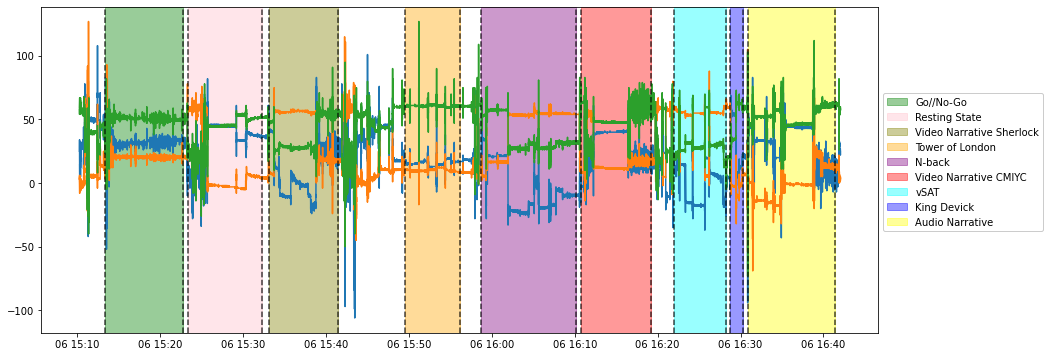

In [21]:
### Accelerometer ###

ACC_df = par.ACC_df

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(ACC_df["datetime"], ACC_df["accel_x"])
ax.plot(ACC_df["datetime"], ACC_df["accel_y"])
ax.plot(ACC_df["datetime"], ACC_df["accel_z"])
plot_exp_regions(par=par_behav, marker_df=marker_ts_df, ax=ax)
ax.legend(bbox_to_anchor=(1.0, 0.75), facecolor='white', framealpha=1)

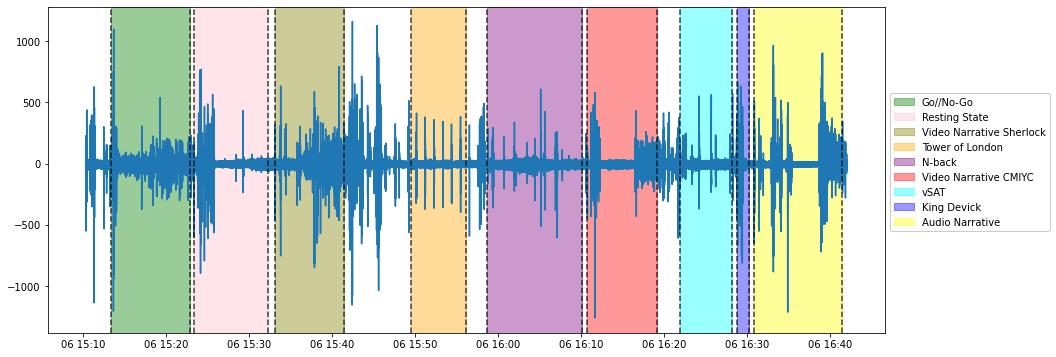

In [22]:
### Photoplethysmograph ###

BVP_df = par.BVP_df

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(BVP_df["datetime"], BVP_df["BVP"])
plot_exp_regions(par=par_behav, marker_df=marker_ts_df, ax=ax)
ax.legend(bbox_to_anchor=(1.0, 0.75), facecolor='white', framealpha=1)

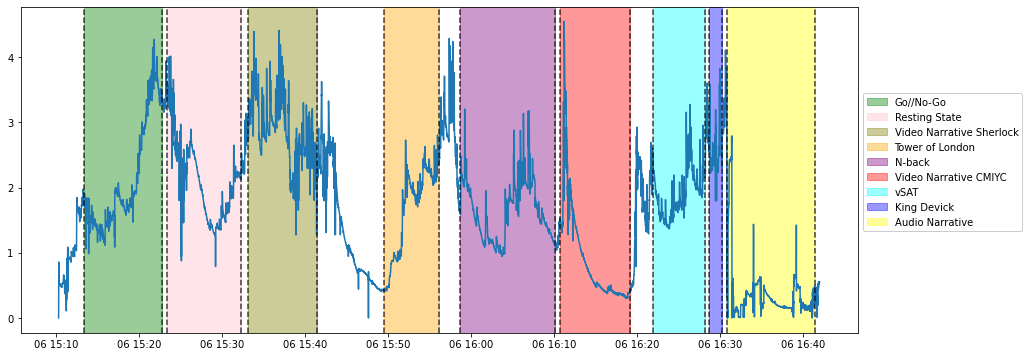

In [23]:
### Electrodermal ###

EDA_df = par.EDA_df

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(EDA_df["datetime"], EDA_df["EDA"])
plot_exp_regions(par=par_behav, marker_df=marker_ts_df, ax=ax)
ax.legend(bbox_to_anchor=(1.0, 0.75), facecolor='white', framealpha=1)

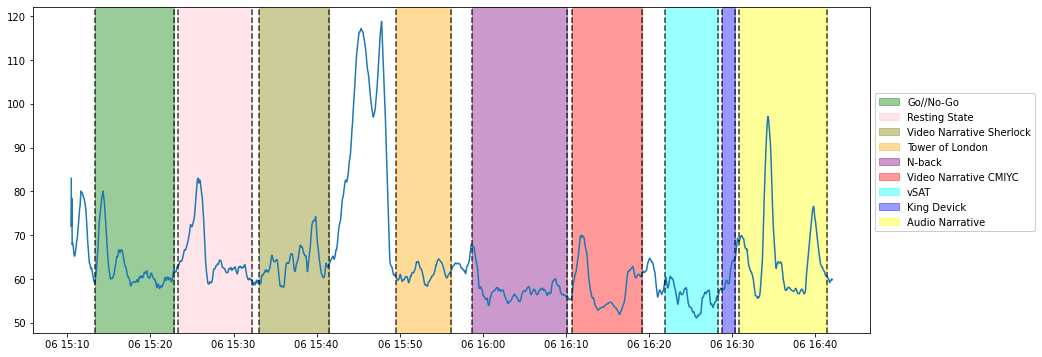

In [24]:
### Heart Rate ###

HR_df = par.HR_df

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(HR_df["datetime"], HR_df["HR"])
plot_exp_regions(par=par_behav, marker_df=marker_ts_df, ax=ax)
ax.legend(bbox_to_anchor=(1.0, 0.75), facecolor='white', framealpha=1)

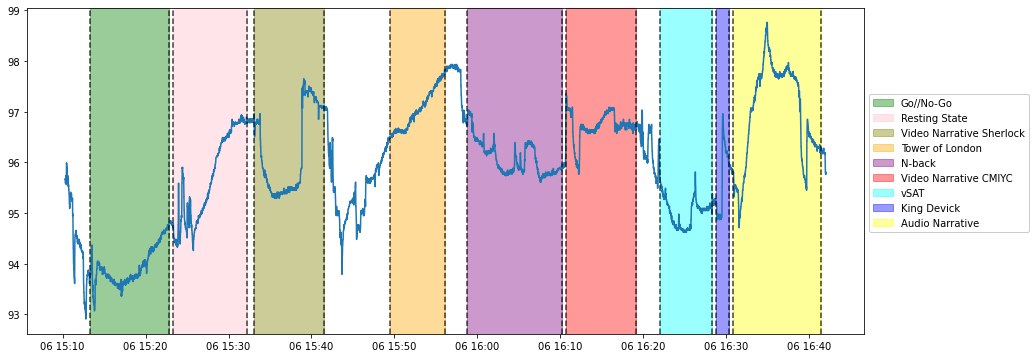

In [25]:
### Temperature ###

TEMP_df = par.TEMP_df

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(TEMP_df["datetime"], TEMP_df["temp_F"])
plot_exp_regions(par=par_behav, marker_df=marker_ts_df, ax=ax)
ax.legend(bbox_to_anchor=(1.0, 0.75), facecolor='white', framealpha=1)